In [1]:
import warnings
from functools import wraps


def ignore_warnings(f):
    @wraps(f)
    def inner(*args, **kwargs):
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("ignore")
            response = f(*args, **kwargs)
        return response
    return inner

In [2]:
import sklearn
import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns
import stream as st

In [3]:
print(st.__version__)
values = (np.load("../BIO_Ml/GSE52588/GSE52588_beta_fn.npz"))["X"]
data = pd.read_csv("../BIO_Ml/GSE52588/GSE52588_samples.csv", delim_whitespace=True)

1.1


In [4]:
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
cpg_names = cpg_names["ID_REF"]
cpg_names = cpg_names.replace(np.nan, "0")
x_cpg = pd.DataFrame(data=values, columns=cpg_names[:422802])
x_cpg["Age"] = data["age"]
x_cpg["Gene_Name"] = gene_names["UCSC_REFGENE_NAME"]

In [5]:
y = x_cpg["Age"]
#y = y.to_numpy()
X = x_cpg.drop(["Age", "Gene_Name"], axis=1)
X.columns.name = None
y = y[29:]
X = X[29:]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
#X = Normalizer().fit_transform(X)

C:\Users\Eugen\AppData\Local\Temp/ipykernel_18140/3606031937.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Graphs/general_density.png", ppi = 400)


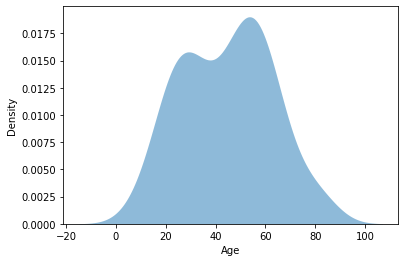

In [6]:
sns.kdeplot(data=y,
            fill=True,
            alpha=0.5,
            palette="crest",
            linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.savefig("Graphs/general_density.png", ppi = 400)
plt.show()

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

selector_k = SelectKBest(score_func=f_regression, k=47)
fit = selector_k.fit(X, y)
cols = selector_k.get_support(indices=True)
X = X.iloc[:, cols]
#X = fit.transform(X)
#X.to_csv('out.zip', index=False, compression="zip")

In [8]:
column_lables = pd.DataFrame(data=X.columns)
column_lables.to_csv("column_lables.csv", index=False, header=False)

In [9]:
# adata = st.read(file_name='out.csv',delimiter=',')
# st.add_cell_labels(adata,file_name='column_lables.csv')
#
# st.plot_visualization_2D(adata, method="umap", n_neighbors=10)
# st.seed_elastic_principal_graph(adata, n_clusters=10,use_vis=True)
# st.plot_dimension_reduction(adata,n_components=2,show_graph=True,show_text=False)
# st.plot_branches(adata,show_text=True)

In [10]:
feature = 12
ox = y
oy = X.iloc[:, feature]

In [11]:
t_df = X
t_df["Age"] = y

i = 0
while i < 4:
    if abs(np.around(np.corrcoef(ox, t_df.iloc[:, i])[0,1], 3)) < 0.9:
        t_df = t_df.drop(t_df.columns[i], axis=1)
        continue
    i+=1

corr = t_df.corr()
corr.style.background_gradient(cmap='coolwarm',
                               vmin=-1,
                               vmax=1)

,cg02711724,cg02711726,cg06931676,Age
cg02711724,1.000000,0.955476,0.865237,0.904374
cg02711726,0.955476,1.000000,0.896174,0.913695
cg06931676,0.865237,0.896174,1.000000,0.940773
Age,0.904374,0.913695,0.940773,1.000000


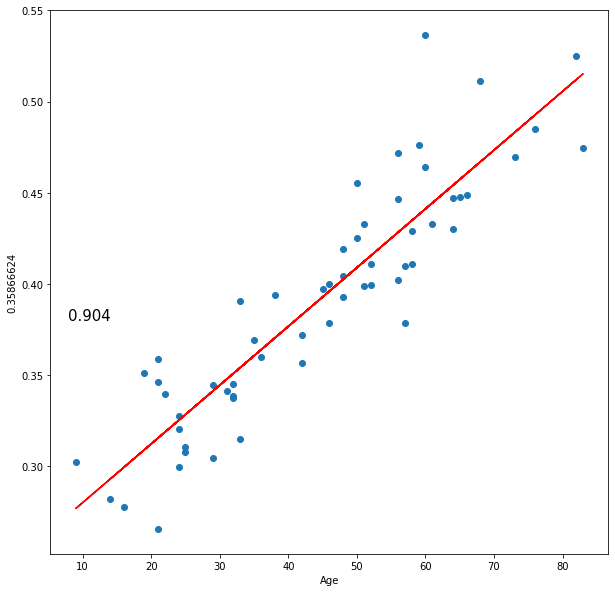

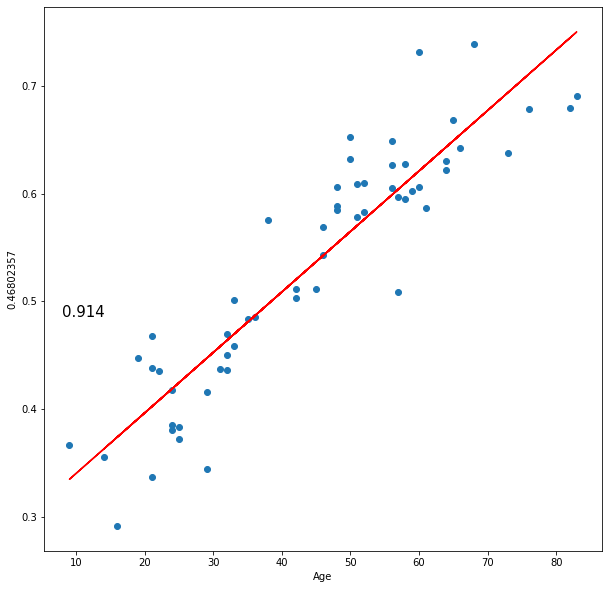

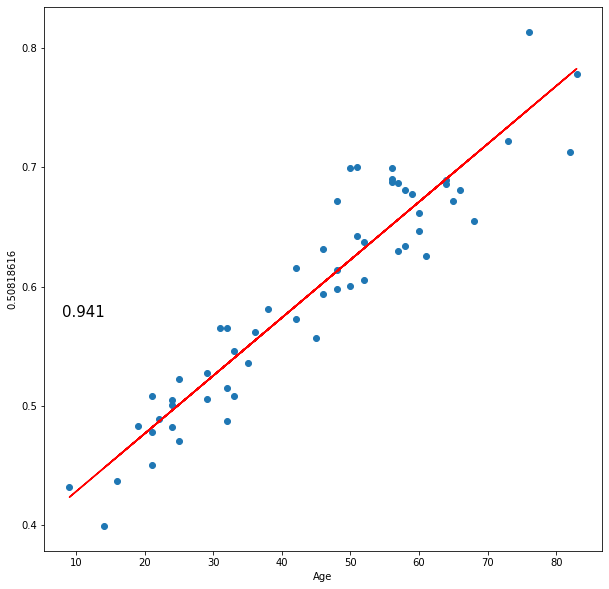

In [12]:
for i in range(i-1):
    oy = t_df.iloc[:, i]
    fig = plt.figure()
    ax = plt.axes()
    m, b = np.polyfit(ox, oy, 1)
    fig.text(0.15, 0.45,
             s=np.around(np.corrcoef(ox,oy)[0,1], 3),
             fontsize=15)
    ax.plot(ox, m * ox + b, c="r")
    ax.scatter(ox, oy)
    plt.xlabel("Age")
    plt.ylabel(oy[0])
    plt.savefig("Graphs/corr_cpg_to_age" + str(i) + ".png")
    fig.show

In [13]:
X = X.drop(["Age"], axis=1)

C:\Users\Eugen\AppData\Local\Temp/ipykernel_18140/222537670.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Graphs/3d_on_2d_cpg.png", ppi = 400)
C:\Users\Eugen\AppData\Local\Temp/ipykernel_18140/222537670.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


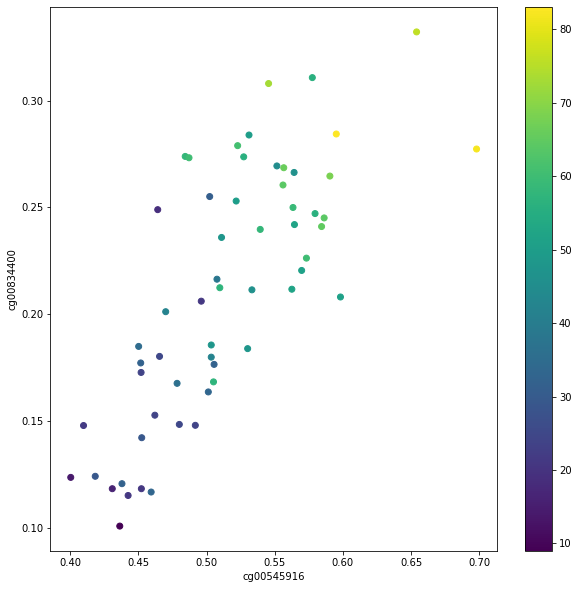

In [14]:
fig3 = plt.figure()
ax = plt.axes()
cpg1 = X.iloc[:, 0]
cpg2 = X.iloc[:, 1]

image = ax.scatter(cpg1, cpg2, c=y)
fig3.colorbar(image, ax=ax)
df_columns = X.columns

plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel(df_columns[0])
plt.ylabel(df_columns[1])
plt.savefig("Graphs/3d_on_2d_cpg.png", ppi = 400)
fig3.show()

In [15]:
gene_names = pd.read_csv("../BIO_Ml/GSE52588/cpgs_annotations.csv")
gene_names = gene_names[["ID_REF", "UCSC_REFGENE_NAME"]]
gene_names = gene_names.replace(np.nan, "0")

important_cpgs = list(X.columns)
gene_names = gene_names[gene_names["ID_REF"].isin(important_cpgs)]
gene_names = gene_names.drop(gene_names[gene_names["UCSC_REFGENE_NAME"] == "0"].index).drop_duplicates()
gene_names = gene_names["UCSC_REFGENE_NAME"].drop_duplicates()

for i in range(len(gene_names)):
    gene_names.iloc[i] = set(gene_names.iloc[i].split(";"))

gene_names = gene_names.reset_index()
gene_names = gene_names["UCSC_REFGENE_NAME"]
# gene_names.to_excel("gene_names_CpG_based.xlsx", index = False)

In [16]:
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev

#regressor = RandomForestRegressor(n_estimators=42, criterion="absolute_error", random_state=42)
regressor = SVR(kernel="poly", C=1.5)
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
lst_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    regressor.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(regressor.score(x_test_fold, y_test_fold))

print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified) * 100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified) * 100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified) * 100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9365935158327888, 0.9339739320678471]

Maximum Accuracy That can be obtained from this model is: 93.65935158327888 %

Minimum Accuracy: 93.39739320678471 %

Overall Accuracy: 93.5283723950318 %

Standard Deviation is: 0.0018523254440765036


c:\users\eugen\pycharmprojects\python_study\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


C:\Users\Eugen\AppData\Local\Temp/ipykernel_18140/2043353776.py:8: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("Graphs/train_test_density.png", ppi = 400)


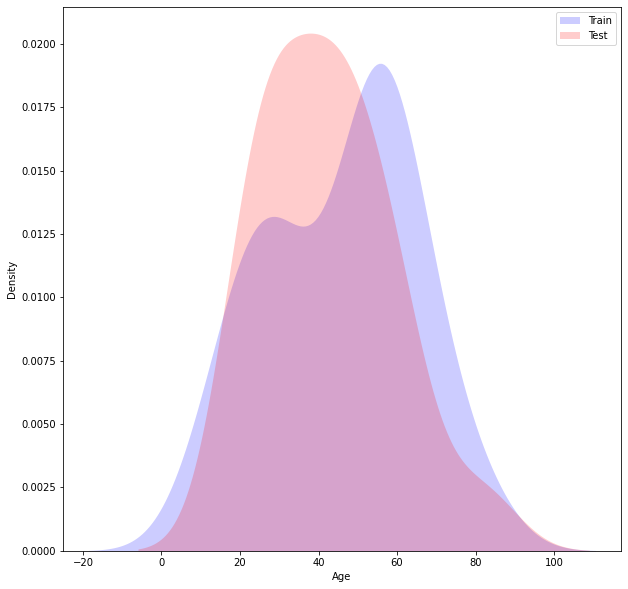

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
sns.kdeplot(y_train, color='b', fill=True, alpha=.2, linewidth=0)
sns.kdeplot(y_test, color="r", fill=True, alpha=.2, linewidth=0)
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["Train", "Test"])
plt.xlabel("Age")
plt.ylabel("Density")
plt.savefig("Graphs/train_test_density.png", ppi = 400)
plt.show()

In [18]:
regressor = SVR(kernel="poly", C=1.5)
model = regressor.fit(X_train, y_train)

In [19]:
y_pred = regressor.predict(X_test)
res = pd.DataFrame({"Actual": y_test, "Predicted": y_pred,
                    "AE": y_test - y_pred,
                    "SE": (y_test - y_pred) ** 2})
print("MAE: ", mean_absolute_error(y_test, y_pred), "MSE: ", mean_squared_error(y_test, y_pred))
print(res)


MAE:  2.762098516425868 MSE:  11.743492524067749
    Actual  Predicted        AE         SE
0       21  24.697489 -3.697489  13.671422
5       24  24.154785 -0.154785   0.023958
34      56  63.967508 -7.967508  63.481184
13      36  33.393307  2.606693   6.794851
44      46  46.285699 -0.285699   0.081624
52      61  55.452921  5.547079  30.770084
37      64  61.614351  2.385649   5.691321
25      33  31.518059  1.481941   2.196148
46      45  40.929887  4.070113  16.565817
12      32  29.439377  2.560623   6.556789
48      82  76.673049  5.326951  28.376405
3       21  23.251983 -2.251983   5.071428
36      51  56.290034 -5.290034  27.984463
31      42  43.374535 -1.374535   1.889346
8       33  31.657185  1.342815   1.803151
17      24  23.284936  0.715064   0.511317
6       25  24.420128  0.579872   0.336251
4       42  45.554992 -3.554992  12.637967
41      56  56.967528 -0.967528   0.936110
19      48  51.080619 -3.080619   9.490216


  0%|          | 0/20 [00:00<?, ?it/s]

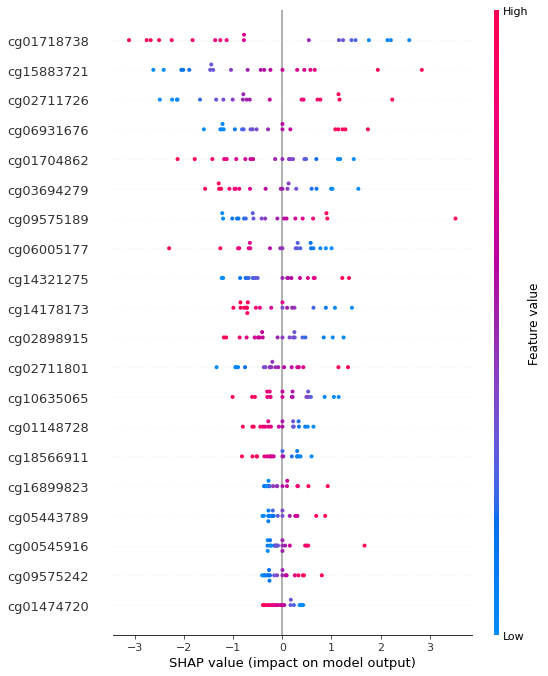

In [20]:
import shap
X_train_summary = shap.kmeans(X_train, 10)
#plt.plot([1, 2], [2, 3])

@ignore_warnings
def kernel_explain(X_train_summary, regressor, X_test):
    ex = shap.KernelExplainer(regressor.predict, X_train_summary)
    shap_values = ex.shap_values(X_test)
    return shap_values, ex

shap_values, ex = kernel_explain(X_train_summary, regressor, X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("Graphs/shap_explanation_sumplot.png")
plt.show()

In [21]:
y_test = y_test.to_numpy()

1.0.1


savefig() got unexpected keyword argument "ppi" which is no longer supported as of 3.3 and will become an error two minor releases later
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


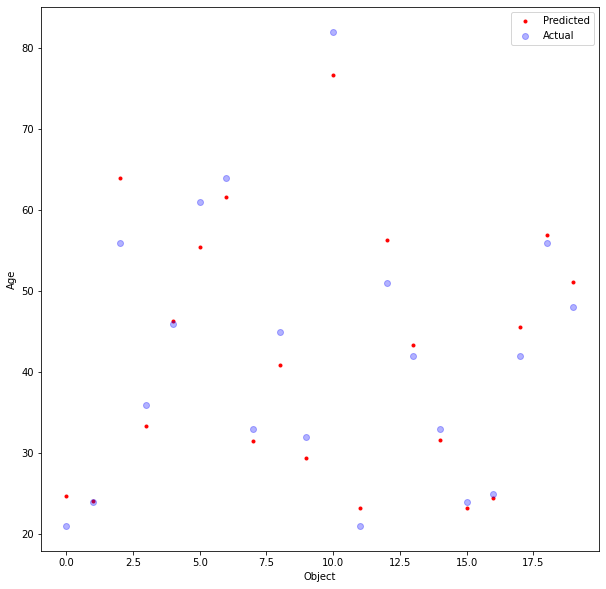

In [22]:
fig4 = plt.figure()
ax = plt.axes()

plt.plot(y_pred, ".", c="r")
plt.plot(y_test, "o", c="b", alpha=0.3)
plt.xlabel("Object")
plt.ylabel("Age")
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(["Predicted", "Actual"])
plt.savefig("Graphs/result.png", ppi = 400)

fig4.show()
print(sklearn.__version__)